# RSOC

## Mesa Tutorial

In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
import numpy as np
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

# For a jupyter notebook add the following line:
%matplotlib inline

# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt

In [2]:
class MoneyAgent(Agent):
    """Agent with fixed intial wealth"""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore = True,
            include_center = False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            self.wealth -= 1
            other = self.random.choice(cellmates)
            other.wealth += 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

In [5]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_of_agents
    B = sum( xi * (N-i) for i, xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyModel(Model):
    """A model with some number of agents"""

    def __init__(self, N, width, height):
        super().__init__()
        self.num_of_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True

        for i in range(self.num_of_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
        
        self.datacollector = DataCollector(
            model_reporters = {"Gini": compute_gini},
            agent_reporters = {"Wealth": "wealth"})

    def plot_state(self):
        agent_counts = np.zeros((self.grid.width, self.grid.height))
        for cell in self.grid.coord_iter():
            cell_content, x, y = cell
            agent_count = len(cell_content)
            agent_counts[x][y] = agent_count
        plt.imshow(agent_counts, interpolation='nearest')
        plt.colorbar()

    def plot_histogram(self):
        agent_wealth = [a.wealth for a in self.schedule.agents]
        plt.hist(agent_wealth)

    def step(self):
        """advance the model by one step"""
        self.datacollector.collect(self)
        self.schedule.step()

In [23]:
mdl = MoneyModel(50, 10, 10)
for i in range(1000):
    if i%500 == 0:
        print(i)
    mdl.step()

0
500


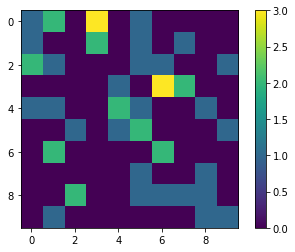

In [24]:
mdl.plot_state()

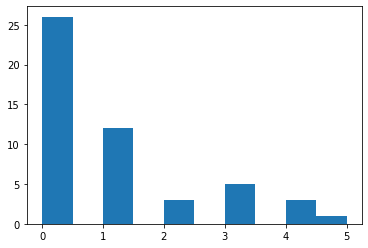

In [25]:
mdl.plot_histogram()

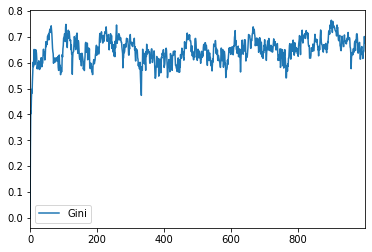

In [26]:
gini = mdl.datacollector.get_model_vars_dataframe()
gini.plot()

In [27]:
agent_wealth = mdl.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

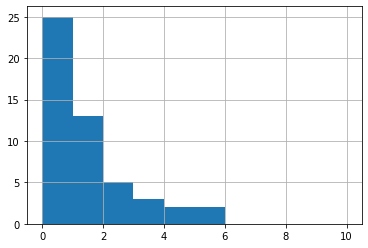

In [29]:
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max() + 1))

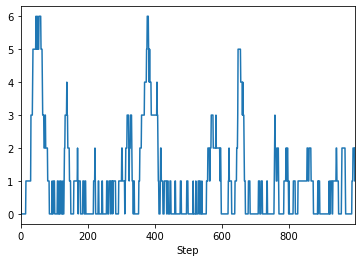

In [30]:
one_agent_wealth = agent_wealth.xs(5, level="AgentID")
one_agent_wealth.Wealth.plot()

## Batch Runner

In [13]:
fixed_params = {
    "width": 10,
    "height": 10
}

variable_params = {"N": range(10, 500, 10)}

# The variables parameters will be invoke along with the fixed parameters allowing for either or both to be honored.
batch_run = BatchRunner(
    MoneyModel,
    variable_params,
    fixed_params,
    iterations = 5,
    max_steps = 100,
    model_reporters = {"Gini": compute_gini}
)

batch_run.run_all()

245it [04:17,  1.05s/it]


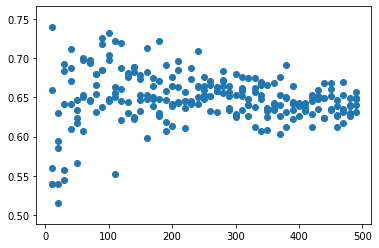

In [14]:
run_data = batch_run.get_model_vars_dataframe()
run_data.head()
plt.scatter(run_data.N, run_data.Gini)

## Visualization

In [1]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule

In [54]:
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.5}

    if agent.wealth > 0:
        portrayal["Color"] = "red"
        portrayal["Layer"] = 0
    else:
        portrayal["Color"] = "grey"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.2
    return portrayal

In [55]:
grid = CanvasGrid(agent_portrayal, 100, 100, 500, 500)
chart = ChartModule([{"Label": "Gini",
                      "Color": "Black"}],
                    data_collector_name='datacollector')

In [50]:
server = ModularServer(MoneyModel,
                       [grid, chart],
                       "Money Model",
                       {"N": 30, "width": 100, "height": 100})
server.port = 8529 # The default
server.launch()

Interface starting at http://127.0.0.1:8528


RuntimeError: This event loop is already running

# Ok, Ants

In [3]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
import numpy as np
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
# For a jupyter notebook add the following line:
%matplotlib inline

# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt

In [15]:
class Ant(Agent):
    """Ant with fixed intial hunger"""

    def __init__(self, unique_id, model, initial_hunger_value = 460):
        super().__init__(unique_id, model)
        self.hunger = initial_hunger_value
        self.state = 'wandering'#feeding, satiated, disturbed
        #intially we have 'eat_seeking' if ant finds food, then he starts 'eating' until he will be 'satisfied'

    def is_satiated(self):
        return self.hunger == 0
    
    def is_food_found(self):
        return self.model.food_array[self.pos[0], self.pos[1]] > 0
    
    def eat(self):
        if self.hunger > 0:
            self.hunger -= 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore = False,
            include_center = False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def disturb(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        for antmate in cellmates:
            if antmate.state == 'feeding':
                antmate.state = 'disturbed' 

    def step(self):
        #movement
        if self.state == 'disturbed':
            self.state = 'wandering'
            self.move()
        elif not self.is_satiated() and not self.is_food_found():
            self.state = 'wandering'
            self.move()
        elif not self.is_satiated() and self.is_food_found():
            self.disturb()
            self.state = 'feeding'
            self.eat()
        elif self.is_satiated():
            self.state = 'satiated'
            self.move()

In [12]:
class AntModel(Model):
    """A model with some number of ants"""

    def __init__(self, av_number_of_drive_ants = 1, number_of_food = 20, width = 20, height = 20):
        super().__init__()

        self.global_agent_index = 1
        self.width = width
        self.height = height

        self.av_number_of_drive_ants = av_number_of_drive_ants

        self.initialize_food_grid(number_of_food)
        self.grid = MultiGrid(width, height, False)
        self.schedule = RandomActivation(self)
        self.running = True
        self.datacollector = DataCollector(
            agent_reporters = {"Hunger": "hunger"})

    def initialize_food_grid(self, number_of_food):
        self.number_of_food = number_of_food
        food_array = np.zeros((self.width*self.height), dtype=int)
        assert number_of_food <= self.width*self.height
        food_array[:number_of_food] = 1
        food_array = np.random.permutation(food_array)
        self.food_array = food_array.reshape((self.width, self.height))

    def add_ant(self, pos):
        assert pos[0] >= 0 and pos[0] <= self.width
        assert pos[1] >= 0 and pos[1] <= self.height
        ant = Ant(self.global_agent_index, self)
        self.schedule.add(ant)
        x,y = pos
        self.grid.place_agent(ant, (x, y))
        self.global_agent_index += 1

    def drive(self):
        number_of_ants_to_add = np.random.poisson(self.av_number_of_drive_ants)

        for i in range(number_of_ants_to_add):

            coordHoriz = (
                np.random.choice([0, self.width - 1]), 
                np.random.randint(self.height))

            coordVert = (
                np.random.randint(self.width),
                np.random.choice([0, self.height - 1]))

            index = np.random.choice([0, 1])
            coord = np.array([coordHoriz, coordVert])[index]

            self.add_ant(coord)

    def topple(self):
        pass

    def satiated_ants_on_boundary(self):
        ants = []
        for ant in self.schedule.agents:
            if ant.is_satiated():
                pos = ant.pos
                if pos[0] == 0 or pos[0] == self.width - 1 or pos[1] == 0 or pos[1] == self.height - 1:
                    ants.append(ant)
        return ants

    def dissipate(self):
        for ant in self.satiated_ants_on_boundary():
            self.schedule.remove(ant)
            self.grid.remove_agent(ant)

    def step(self):
        """advance the model by one step"""
        self.drive()
        self.topple()
        self.dissipate()
        self.datacollector.collect(self)
        self.schedule.step()

    def plot_state(self):
        agent_counts = np.zeros((self.grid.width, self.grid.height))
        for cell in self.grid.coord_iter():
            cell_content, x, y = cell
            agent_count = len(cell_content)
            agent_counts[x][y] = agent_count
        plt.imshow(agent_counts, interpolation = 'nearest')
        plt.colorbar()

    def plot_food(self):
        plt.imshow(self.food_array)

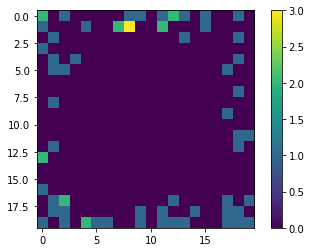

In [16]:
mdl = AntModel(av_number_of_drive_ants = 10, number_of_food = 10,  width = 20, height = 20)

mdl.step()

mdl.plot_state()

In [18]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer

def agent_portrayal(agent):
    portrayal = {
        "Shape": "circle",
        "Filled": "true",
        "r": 1,
        "Color": "red",
        "Layer": 0,
        "text": agent.hunger,
        "text_color": "black"}

    if agent.state == 'wandering':
        portrayal["Color"] = "red"
        portrayal["Layer"] = 0
    elif agent.state == 'feeding':
        portrayal["Color"] = "yellow"
        portrayal["Layer"] = 1
    elif agent.state == 'satiated':
        portrayal["Color"] = "green"
        portrayal["Layer"] = 2
    elif agent.state == 'disturbed':
        portrayal["Color"] = "black"
        portrayal["Layer"] = 3

    return portrayal

grid = CanvasGrid(agent_portrayal, 30, 30, 700, 700)
server = ModularServer(AntModel,
                       [grid],
                       "Rapid Self-Organized Criticality",
                       {"av_number_of_drive_ants": 0.05, "number_of_food" : 30, "width": 30, "height": 30})
server.port = 8551 # The default
server.launch()

Interface starting at http://127.0.0.1:8551


RuntimeError: This event loop is already running